## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

## Calibrate Camera

In [2]:

def detect_chessboard_corners(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    img_shape = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img_shape = gray.shape[::-1]
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints,imgpoints,img_shape

def calibrate_camera(images):
    
    objpoints,imgpoints,img_shape = detect_chessboard_corners(images)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    
    return mtx,dist
    
    
def undistort_camera_image(mtx,dist,img):
    
    return cv2.undistort(img, mtx, dist, None, mtx)

def calibration_undistortion_pipeline(chessboard_images, distorted_image):
    
    mtx,dist = calibrate_camera(chessboard_images)
    undistorted_img = undistort_camera_img(mtx,dist,distorted_image)
    
    return undistorted_img
    
    

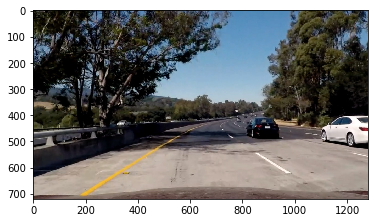

In [3]:
test_images = glob.glob('test_images/*.jpg')
calibration_images = glob.glob('camera_cal/calibration*.jpg')


distorted_image = test_images[1]
if not os.path.exists("readme_images"):
    os.mkdir('readme_images')

mtx,dist = calibrate_camera(calibration_images)
undistorted_img = undistort_camera_image(mtx,dist, cv2.imread(distorted_image))

cv2.imwrite("readme_images/"+ "undistorted_image.jpg",undistorted_img)
plt.imshow(cv2.cvtColor(undistorted_img,cv2.COLOR_BGR2RGB))


## Compute Threshold Binary Image

In [4]:
def color_threshold(img, s_threshold=(0, 255)):
    
    hls =cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    S=hls[:,:,2]
    binary_output=np.zeros_like(S)
    binary_output[(S >s_threshold[0]) & (S<=s_threshold[1])]=1 
    return binary_output

def abs_sobel_threshold(img, orient='x', sobel_kernel=3, coordinate_threshold=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel =np.zeros_like(gray)
    
    if orient =='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel)
        
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel)
        
    abs_gradient = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_gradient/np.max(abs_gradient))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= coordinate_threshold[0]) & (scaled_sobel <= coordinate_threshold[1])] = 1
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_threshold=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    mag_grad = np.sqrt((sobelx**2)+(sobely**2))
    scaled_grad = np.uint8(255*mag_grad/np.max(mag_grad))
    binary_output = np.zeros_like(scaled_grad)
    binary_output[(scaled_grad >= mag_threshold[0]) & (scaled_grad <= mag_threshold[1])]=1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, dir_threshold=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely,abs_sobelx)
    binary_output = np.zeros_like(gray)
    binary_output [(grad_dir >= dir_threshold[0]) & (grad_dir <= dir_threshold[1])]=1
    return binary_output

def combined_threshold(img,  orient='x', sobel_kernel=3, s_threshold=(0,255), coordinate_threshold=(0, 255)):
    
    binary_x = abs_sobel_threshold(img, orient, sobel_kernel, coordinate_threshold)
    binary_color = color_threshold(img, s_threshold)
    combined_binary = np.zeros_like(binary_color)
    combined_binary[(binary_x ==1) | (binary_color ==1)] = 1
    
    return combined_binary
    

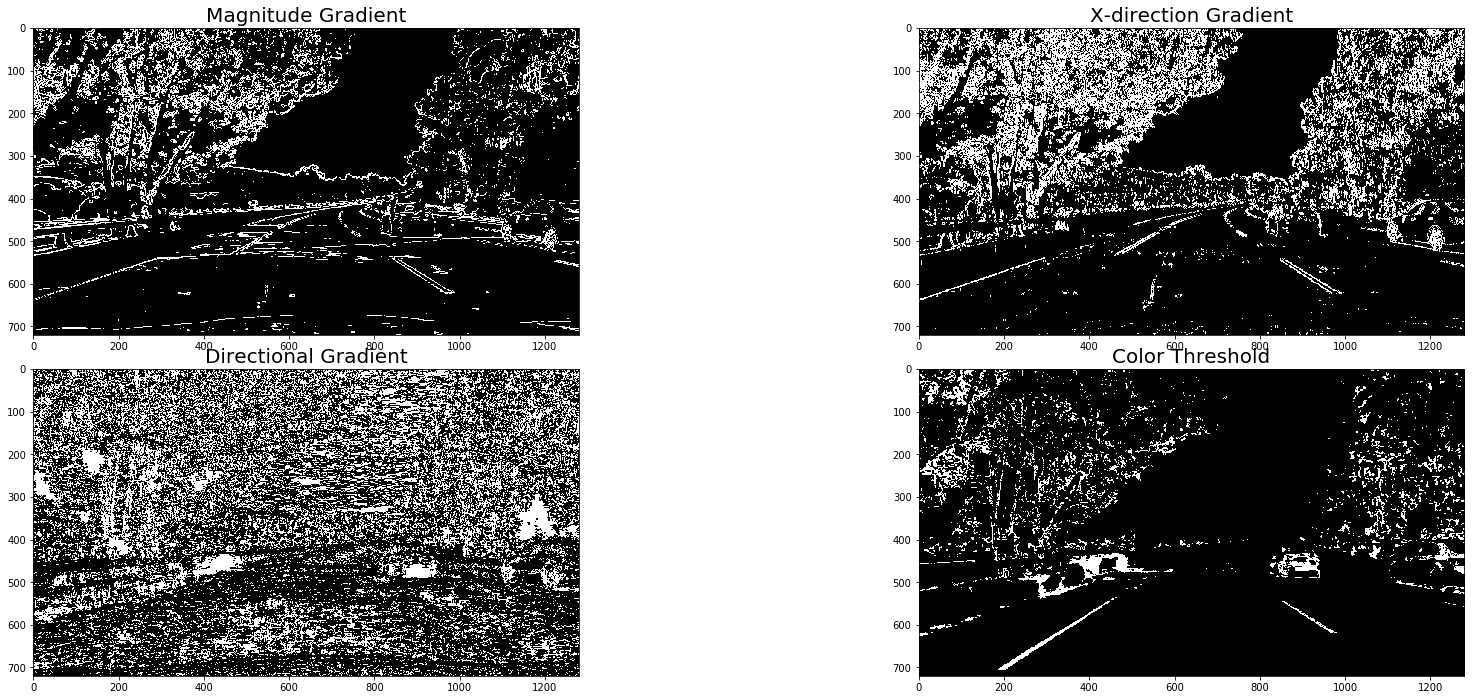

In [5]:
binary_mag = mag_thresh(undistorted_img,mag_threshold=(30, 100))
binary_x = abs_sobel_threshold(undistorted_img, coordinate_threshold=(10, 100))
binary_dir = dir_threshold(undistorted_img, dir_threshold=(0, 0.6))
binary_color = color_threshold(undistorted_img, s_threshold=(180, 255))

cv2.imwrite("readme_images/magnitude_gradient.jpg",binary_mag * 255)
cv2.imwrite("readme_images/x-dir_gradient.jpg",binary_x * 255)
cv2.imwrite("readme_images/dir_gradient.jpg",binary_dir * 255)
cv2.imwrite("readme_images/color_threshold.jpg",binary_color * 255)

f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
font_size = 20
axes[0,0].imshow(binary_mag, cmap = 'gray')
axes[0,0].set_title('Magnitude Gradient', fontsize=font_size)

axes[0,1].imshow(binary_x, cmap='gray')
axes[0,1].set_title('X-direction Gradient', fontsize=font_size)

axes[1,0].imshow(binary_dir, cmap='gray')
axes[1,0].set_title('Directional Gradient', fontsize=font_size)

axes[1,1].imshow(binary_color, cmap='gray')
axes[1,1].set_title('Color Threshold', fontsize=font_size)

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

Text(0.5,1,'combined Threshold')

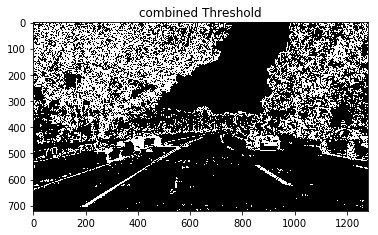

In [6]:
combined_binary = combined_threshold(undistorted_img, coordinate_threshold=(10, 100), s_threshold=(180, 255))

cv2.imwrite("readme_images/combined_threshold.jpg",combined_binary*255)
plt.imshow(combined_binary, cmap='gray')
plt.title('combined Threshold')

## Perspective Transform

In [7]:
def transform_to_birdseye_view(img):
    
    h, w = img.shape[:2]
    src = np.float32([[w, h-10],[0, h-10],[546, 460],[732, 460]])  
    dst = np.float32([[w, h],[0, h],[0, 0],[w, 0]])      
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)
    
    return warped_img,M,Minv

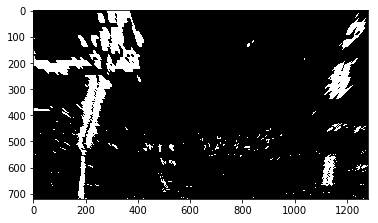

In [8]:
birdeye_img,_,_ = transform_to_birdseye_view(combined_binary)
cv2.imwrite("readme_images/warped_image.jpg",birdeye_img * 255)
plt.imshow(birdeye_img, cmap = 'gray')

## Find lane Boundary

In [9]:
def detect_lane_start_points(img):
    
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

def find_lane_pixels(img, nwindows=9, window_width=100, min_pixels=50):
    
    # Take a histogram of the bottom half of the image
    histogram = detect_lane_start_points(img)
    # Create an output image to draw on and visualize the output
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        # Get window boundaries #
        win_xleft_low = leftx_current - window_width
        win_xleft_high = leftx_current + window_width  
        win_xright_low = rightx_current - window_width 
        win_xright_high = rightx_current + window_width 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window#
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # recenter right or leftx_current based on their mean position #
        if len(good_left_inds) > min_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pixels:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        pass
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    
    poly_valid = True
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    poly = [left_fit, right_fit]
    
    leftr_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    rightr_fit = np.polyfit(righty * ym_per_pix , rightx * xm_per_pix, 2)
    poly_real = [leftr_fit, rightr_fit]
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        poly_valid = False
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    return left_fitx, right_fitx, ploty, poly , poly_real, poly_valid


def search_around_poly(binary_warped, prev_poly,  margin = 100, verbose = False):
        
    margin = 100
    left_fit, right_fit = prev_poly
        
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    # Search for activated pixels around the poly #
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
        
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    # Fit new polynomials
    left_fitx, right_fitx, ploty, poly, poly_real, poly_valid = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        
    
    if (verbose == True):
        
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
    
    return ploty,left_fitx, right_fitx,poly,poly_real, poly_valid

def fit_polynomial(img, deg=2, nwindows=9, window_width=100, min_pixels=50,  ym_per_pix = 30/720,
                   xm_per_pix = 3.7/700, verbose=False):
    
    
    poly_valid = True
    # Find our lane pixels first
    leftxp, leftyp, rightxp, rightyp, out_img = find_lane_pixels(img)

    #Fit a second order polynomial#
    left_fit = np.polyfit(leftyp,leftxp,2)
    right_fit = np.polyfit(rightyp,rightxp,2)
    poly = [left_fit, right_fit]
    
    #fit polynomial to calculate real world curvature
    left_fit_real = np.polyfit(leftyp*ym_per_pix,leftxp*xm_per_pix,2)
    right_fit_real = np.polyfit(rightyp*ym_per_pix,rightxp*xm_per_pix,2)
    poly_real = [left_fit_real,right_fit_real]

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        poly_valid = False

   
    if verbose == True:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[leftyp, leftxp] = [255, 0, 0]
        out_img[rightyp, rightxp] = [0, 0, 255]
        
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)

    return ploty,left_fitx, right_fitx,poly,poly_real,poly_valid


    

    

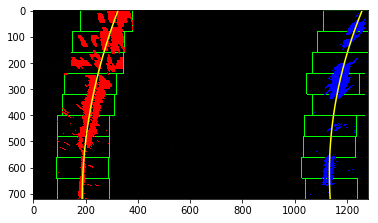

In [10]:
ploty,left_fitx, right_fitx,poly,poly_real,poly_valid = fit_polynomial(birdeye_img, verbose=True)

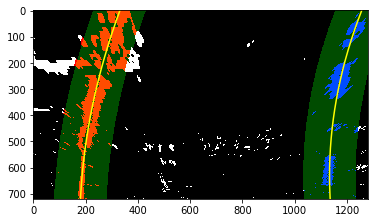

In [11]:
_,_, _,_,_, _ = search_around_poly(birdeye_img, poly,verbose = True)

## Lane measurements and Plotting

In [17]:
def measure_lane_curvature(img,poly_real, ym_per_pix = 30/720):
    
    left_fit , right_fit = poly_real
    
    # Define y-value where we want radius of curvature
    y_eval = img.shape[0] * ym_per_pix
    
    #calculation of curve radius#
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**(1.5) / np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**(1.5) / np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

def get_vehicle_position_from_center(img, poly, xm_per_pix = 3.7/700 ):
    
    vehicle_center = img.shape[1]//2
    left_fit, right_fit = poly
    lane_center = (right_fit[2] - left_fit[2])/2
    
    return ((vehicle_center - lane_center) * xm_per_pix )

def line_sanity_checks (poly,left_line_curv, right_line_curv):
    #check line are parallel
    left_fit, right_fit = poly
    left_slope = 2*left_fit[0]+ left_fit[1]
    right_slope = 2*right_fit[0]+ right_fit[1]
    slope_diff = np.absolute(left_slope - right_slope)

    # check they have similar curvature
    curvature_diff =np.absolute(left_line_curv - right_line_curv)
    print("slope diff = {}". format(slope_diff))
    print("curvature diff = {}". format(curvature_diff))

def project_on_original_image(undistorted_img,binary_warped_img, Minv, left_fitx, right_fitx , 
                              vehicle_position_offset, left_curverad, right_curverad):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    vehicle_pos_offset_txt = "Vehicle pos from center = {} m" .format(np.around(vehicle_position_offset,
                                                                              decimals=2))
    left_curvature_txt = "Lane Curvature = {} km" . format(np.around(left_curverad/1000, decimals=2))
    cv2.putText(result,vehicle_pos_offset_txt,(10,50), cv2.FONT_HERSHEY_SIMPLEX,2, (255,0,0),4)
    cv2.putText(result,left_curvature_txt,(10,150), cv2.FONT_HERSHEY_SIMPLEX,2, (255,0,0),4)
    
    return result

## Line Class to track frames

In [31]:

class Line():
    def __init__(self, buffer_size):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.x_left_nframes = []
        self.x_right_nframes = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False]),np.array([False])]
        #Real world polynomial coefficients for the most recent fit
        self.current_fit_rw = [np.array([False]),np.array([False])]
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for right line pixels
        self.rightlanex = None
        #x values for right line pixels
        self.leftlanex = None  
        #y values for detected line pixels
        self.ally = None
        #y values for detected line pixels for n frames
        self.y_nframes = []
        #number of frames to aggregate
        self.nframes = buffer_size
        #current frame no.
        self.frame_count = 0
        

    def update_params(self,detected_line_status, ploty, left_fitx, right_fitx, poly,
                      poly_real, poly_valid):
        
        self.detected = detected_line_status
        self.frame_count +=1
        if(self.frame_count == 1):
            self.current_fit = poly
            self.current_fit_rw = poly_real
            self.leftlanex = left_fitx
            self.rightlanex = right_fitx
        else:
            self.smooth_lines(ploty,poly,poly_real)
            print('###### smoothing ########')
            
        self.ally = ploty
        
    def smooth_lines(self, ploty, poly, poly_real, coeff = 0.4):
        
        left_fit_prev , right_fit_prev = self.current_fit
        left_fit_curr, right_fit_curr = poly
        
        left_fit = left_fit_curr * (1-coeff) + left_fit_prev * coeff
        
        right_fit = right_fit_curr * (1-coeff) + right_fit_prev * coeff
        
        self.current_fit = [left_fit,right_fit]
        
        self.leftlanex = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        self.rightlanex = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Real world poly
        left_fit_prev , right_fit_prev = self.current_fit_rw
        left_fit_curr, right_fit_curr = poly_real
        
        left_fit = left_fit_curr * (1-coeff) + left_fit_prev * coeff
        
        right_fit = right_fit_curr * (1-coeff) + right_fit_prev * coeff
        
        self.current_fit_rw = [left_fit,right_fit]
        
            

            
        
        
            

In [28]:
z = np.polyfit([1.2,2.9,4.5],[3,4,5],2)
z*0.4

array([0.00445633, 0.21702317, 0.93315508])

## Image Testing Pipeline

In [19]:
def image_lane_finding_pipeline(img):
    
    undistorted_img = undistort_camera_image(mtx,dist, img)
    
    combined_binary = combined_threshold(undistorted_img, coordinate_threshold=(10, 100), s_threshold=(180, 255))
    
    birdeye_img,M,Minv = transform_to_birdseye_view(combined_binary)
    
    ploty,left_fitx, right_fitx,poly,poly_real,poly_valid= fit_polynomial(birdeye_img)
    
    left_lane_crv, right_lane_crv= measure_lane_curvature(birdeye_img, poly_real)
    
    veh_position_offset = get_vehicle_position_from_center(undistorted_img,poly)
    
    result= project_on_original_image(undistorted_img,birdeye_img, Minv, left_fitx, right_fitx,
                              veh_position_offset, left_lane_crv, right_lane_crv )
    
    return result

__Run pipeline on test images and store images with lane markings__

In [20]:
test_images = glob.glob('test_images/*.jpg')
calibration_images = glob.glob('camera_cal/calibration*.jpg')

mtx,dist = calibrate_camera(calibration_images)

for test_image in test_images:
    
    image_name = test_image.split('/')[1]
    dist_img = cv2.imread(test_image)
    
    result = image_lane_finding_pipeline(dist_img)
    
    cv2.imwrite("output_images/"+ "with_lane_markings_"+image_name,result) 

## Video Testing Pipeline

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:

def video_lane_finding_pipeline(image):
    undistorted_img = undistort_camera_image(mtx,dist, image)
    combined_binary = combined_threshold(undistorted_img, coordinate_threshold=(10, 100),
                                         s_threshold=(180, 255))
    birdeye_img, M, Minv = transform_to_birdseye_view(combined_binary)
    
    if (current_line.detected == False):
        ploty,left_fitx, right_fitx,poly,poly_real,poly_valid = fit_polynomial(birdeye_img)
        current_line.update_params(poly_valid, ploty, left_fitx,
                                     right_fitx, poly, poly_real, poly_valid)
    else:
        
        ploty,left_fitx, right_fitx,poly,poly_real, poly_valid= search_around_poly(birdeye_img,
                                                                                   current_line.current_fit)
        current_line.update_params(poly_valid, ploty, left_fitx,
                                     right_fitx, poly, poly_real, poly_valid)
        

    left_lane_crv, right_lane_crv= measure_lane_curvature(birdeye_img, current_line.current_fit_rw)
    
    veh_position_offset = get_vehicle_position_from_center(undistorted_img,current_line.current_fit)
    
    return project_on_original_image(undistorted_img,birdeye_img, Minv, current_line.leftlanex,  
                                current_line.rightlanex,
                              veh_position_offset, left_lane_crv, right_lane_crv )


__Run pipeline on video an store output video with lane markings__

In [34]:
buffer_size = 6
current_line = Line(buffer_size)
mtx,dist = calibrate_camera(calibration_images)
clip1 = VideoFileClip('project_video.mp4')
navigation_clip = clip1.fl_image(video_lane_finding_pipeline) 
%time navigation_clip.write_videofile('out_project_video.mp4', audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video out_project_video.mp4.
Moviepy - Writing video out_project_video.mp4

###### smoothing ########
###### smoothing ########



t:   1%|          | 7/1260 [00:00<01:16, 16.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   1%|          | 9/1260 [00:00<01:18, 15.90it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   1%|          | 13/1260 [00:00<01:20, 15.40it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   1%|          | 15/1260 [00:00<01:24, 14.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   2%|▏         | 19/1260 [00:01<01:23, 14.92it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   2%|▏         | 21/1260 [00:01<01:24, 14.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   2%|▏         | 27/1260 [00:01<01:22, 14.96it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   2%|▏         | 29/1260 [00:01<01:22, 14.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   3%|▎         | 33/1260 [00:02<01:21, 15.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   3%|▎         | 37/1260 [00:02<01:21, 14.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   3%|▎         | 41/1260 [00:02<01:21, 15.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   4%|▎         | 45/1260 [00:03<01:28, 13.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   4%|▎         | 47/1260 [00:03<01:35, 12.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   4%|▍         | 51/1260 [00:03<01:38, 12.27it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   4%|▍         | 53/1260 [00:03<01:41, 11.84it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   5%|▍         | 57/1260 [00:04<01:40, 11.93it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   5%|▍         | 59/1260 [00:04<01:39, 12.11it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   5%|▌         | 63/1260 [00:04<01:39, 12.07it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   5%|▌         | 65/1260 [00:04<01:41, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   5%|▌         | 69/1260 [00:05<01:42, 11.63it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   6%|▌         | 71/1260 [00:05<01:42, 11.64it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   6%|▌         | 75/1260 [00:05<01:41, 11.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   6%|▌         | 77/1260 [00:05<01:40, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   6%|▋         | 79/1260 [00:06<01:52, 10.53it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   6%|▋         | 81/1260 [00:06<01:55, 10.25it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   7%|▋         | 84/1260 [00:06<02:05,  9.34it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   7%|▋         | 87/1260 [00:06<02:04,  9.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   7%|▋         | 90/1260 [00:07<01:56, 10.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   7%|▋         | 92/1260 [00:07<01:59,  9.80it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   7%|▋         | 94/1260 [00:07<02:06,  9.20it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   8%|▊         | 96/1260 [00:07<02:09,  9.01it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   8%|▊         | 98/1260 [00:08<02:11,  8.83it/s, now=None]

###### smoothing ########
###### smoothing ########



t:   8%|▊         | 101/1260 [00:08<01:56,  9.93it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   8%|▊         | 103/1260 [00:08<01:51, 10.37it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   8%|▊         | 105/1260 [00:08<01:46, 10.82it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   9%|▊         | 109/1260 [00:09<01:48, 10.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   9%|▉         | 113/1260 [00:09<01:44, 10.99it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   9%|▉         | 115/1260 [00:09<01:41, 11.25it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:   9%|▉         | 119/1260 [00:09<01:44, 10.87it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  10%|▉         | 121/1260 [00:10<01:41, 11.17it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  10%|▉         | 125/1260 [00:10<01:40, 11.32it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  10%|█         | 127/1260 [00:10<01:40, 11.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  10%|█         | 131/1260 [00:10<01:40, 11.20it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  11%|█         | 133/1260 [00:11<01:36, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  11%|█         | 135/1260 [00:11<01:38, 11.40it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  11%|█         | 139/1260 [00:11<01:39, 11.28it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  11%|█▏        | 143/1260 [00:12<01:38, 11.37it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  12%|█▏        | 145/1260 [00:12<01:37, 11.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  12%|█▏        | 149/1260 [00:12<01:34, 11.72it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  12%|█▏        | 151/1260 [00:12<01:33, 11.85it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  12%|█▏        | 155/1260 [00:13<01:34, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  12%|█▏        | 157/1260 [00:13<01:32, 11.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  13%|█▎        | 161/1260 [00:13<01:32, 11.85it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  13%|█▎        | 163/1260 [00:13<01:30, 12.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  13%|█▎        | 167/1260 [00:14<01:31, 11.92it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  13%|█▎        | 169/1260 [00:14<01:35, 11.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  14%|█▎        | 173/1260 [00:14<01:30, 12.02it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  14%|█▍        | 175/1260 [00:14<01:30, 11.95it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  14%|█▍        | 179/1260 [00:15<01:29, 12.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  14%|█▍        | 181/1260 [00:15<01:30, 11.95it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  15%|█▍        | 185/1260 [00:15<01:30, 11.83it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  15%|█▍        | 187/1260 [00:15<01:28, 12.10it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  15%|█▌        | 191/1260 [00:16<01:31, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  15%|█▌        | 193/1260 [00:16<01:27, 12.15it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  15%|█▌        | 195/1260 [00:16<01:33, 11.40it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  16%|█▌        | 199/1260 [00:16<01:33, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  16%|█▌        | 203/1260 [00:17<01:31, 11.51it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  16%|█▋        | 205/1260 [00:17<01:35, 11.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  17%|█▋        | 209/1260 [00:17<01:30, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  17%|█▋        | 211/1260 [00:17<01:30, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  17%|█▋        | 215/1260 [00:18<01:26, 12.05it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  17%|█▋        | 217/1260 [00:18<01:30, 11.58it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  18%|█▊        | 221/1260 [00:18<01:27, 11.82it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  18%|█▊        | 223/1260 [00:18<01:29, 11.64it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  18%|█▊        | 227/1260 [00:19<01:30, 11.41it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  18%|█▊        | 229/1260 [00:19<01:30, 11.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  18%|█▊        | 233/1260 [00:19<01:27, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  19%|█▊        | 235/1260 [00:19<01:28, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  19%|█▉        | 239/1260 [00:20<01:28, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  19%|█▉        | 241/1260 [00:20<01:24, 12.06it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  19%|█▉        | 245/1260 [00:20<01:24, 12.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  20%|█▉        | 247/1260 [00:20<01:24, 11.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  20%|█▉        | 251/1260 [00:21<01:25, 11.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  20%|██        | 253/1260 [00:21<01:24, 11.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  20%|██        | 257/1260 [00:21<01:20, 12.40it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  21%|██        | 259/1260 [00:21<01:21, 12.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  21%|██        | 263/1260 [00:22<01:24, 11.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  21%|██        | 265/1260 [00:22<01:24, 11.78it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  21%|██        | 267/1260 [00:22<01:25, 11.67it/s, now=None]


###### smoothing ########
###### smoothing ########
###### smoothing ########


t:  22%|██▏       | 271/1260 [00:23<01:32, 10.70it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  22%|██▏       | 275/1260 [00:23<01:31, 10.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  22%|██▏       | 277/1260 [00:23<01:28, 11.10it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  22%|██▏       | 281/1260 [00:23<01:26, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  22%|██▏       | 283/1260 [00:24<01:24, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  23%|██▎       | 287/1260 [00:24<01:21, 11.92it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  23%|██▎       | 289/1260 [00:24<01:23, 11.64it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  23%|██▎       | 293/1260 [00:24<01:21, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  23%|██▎       | 295/1260 [00:25<01:21, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  24%|██▎       | 299/1260 [00:25<01:18, 12.25it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  24%|██▍       | 301/1260 [00:25<01:18, 12.18it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  24%|██▍       | 305/1260 [00:25<01:19, 11.95it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  24%|██▍       | 307/1260 [00:26<01:18, 12.17it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  25%|██▍       | 311/1260 [00:26<01:18, 12.02it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  25%|██▍       | 313/1260 [00:26<01:21, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  25%|██▌       | 317/1260 [00:26<01:22, 11.48it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  25%|██▌       | 319/1260 [00:27<01:21, 11.54it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  26%|██▌       | 323/1260 [00:27<01:22, 11.41it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  26%|██▌       | 325/1260 [00:27<01:20, 11.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  26%|██▌       | 329/1260 [00:27<01:22, 11.28it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  26%|██▋       | 331/1260 [00:28<01:20, 11.51it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  27%|██▋       | 335/1260 [00:28<01:21, 11.39it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  27%|██▋       | 337/1260 [00:28<01:25, 10.74it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  27%|██▋       | 339/1260 [00:28<01:24, 10.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  27%|██▋       | 343/1260 [00:29<01:20, 11.38it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  27%|██▋       | 345/1260 [00:29<01:21, 11.26it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  28%|██▊       | 349/1260 [00:29<01:21, 11.15it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  28%|██▊       | 351/1260 [00:29<01:20, 11.33it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  28%|██▊       | 355/1260 [00:30<01:16, 11.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  28%|██▊       | 357/1260 [00:30<01:18, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  29%|██▊       | 361/1260 [00:30<01:16, 11.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  29%|██▉       | 363/1260 [00:30<01:16, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  29%|██▉       | 367/1260 [00:31<01:17, 11.59it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  29%|██▉       | 369/1260 [00:31<01:15, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  30%|██▉       | 373/1260 [00:31<01:14, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  30%|██▉       | 375/1260 [00:31<01:13, 11.99it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  30%|███       | 379/1260 [00:32<01:15, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  30%|███       | 381/1260 [00:32<01:13, 11.95it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  31%|███       | 385/1260 [00:32<01:14, 11.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  31%|███       | 387/1260 [00:33<01:14, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  31%|███       | 391/1260 [00:33<01:16, 11.34it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  31%|███       | 393/1260 [00:33<01:14, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  32%|███▏      | 397/1260 [00:33<01:12, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  32%|███▏      | 399/1260 [00:34<01:12, 11.80it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  32%|███▏      | 403/1260 [00:34<01:11, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  32%|███▏      | 405/1260 [00:34<01:10, 12.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  32%|███▏      | 409/1260 [00:34<01:12, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  33%|███▎      | 411/1260 [00:35<01:11, 11.88it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  33%|███▎      | 415/1260 [00:35<01:12, 11.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  33%|███▎      | 417/1260 [00:35<01:11, 11.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  33%|███▎      | 421/1260 [00:35<01:12, 11.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  34%|███▎      | 423/1260 [00:36<01:12, 11.58it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  34%|███▍      | 427/1260 [00:36<01:12, 11.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  34%|███▍      | 429/1260 [00:36<01:11, 11.63it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  34%|███▍      | 433/1260 [00:36<01:11, 11.64it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  35%|███▍      | 435/1260 [00:37<01:10, 11.69it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  35%|███▍      | 439/1260 [00:37<01:09, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  35%|███▌      | 441/1260 [00:37<01:09, 11.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  35%|███▌      | 445/1260 [00:37<01:11, 11.41it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  35%|███▌      | 447/1260 [00:38<01:09, 11.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  36%|███▌      | 451/1260 [00:38<01:09, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  36%|███▌      | 453/1260 [00:38<01:09, 11.58it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  36%|███▋      | 457/1260 [00:39<01:09, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  36%|███▋      | 459/1260 [00:39<01:08, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  37%|███▋      | 463/1260 [00:39<01:07, 11.85it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  37%|███▋      | 465/1260 [00:39<01:06, 11.88it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  37%|███▋      | 469/1260 [00:40<01:08, 11.61it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  37%|███▋      | 471/1260 [00:40<01:08, 11.54it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  38%|███▊      | 475/1260 [00:40<01:05, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  38%|███▊      | 477/1260 [00:40<01:06, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  38%|███▊      | 481/1260 [00:41<01:07, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  38%|███▊      | 483/1260 [00:41<01:07, 11.47it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  39%|███▊      | 487/1260 [00:41<01:03, 12.13it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  39%|███▉      | 489/1260 [00:41<01:03, 12.07it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  39%|███▉      | 493/1260 [00:42<01:01, 12.42it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  39%|███▉      | 495/1260 [00:42<01:04, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  40%|███▉      | 499/1260 [00:42<01:04, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  40%|███▉      | 501/1260 [00:42<01:03, 11.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  40%|████      | 505/1260 [00:43<01:05, 11.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  40%|████      | 507/1260 [00:43<01:06, 11.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  41%|████      | 511/1260 [00:43<01:04, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  41%|████      | 513/1260 [00:43<01:05, 11.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  41%|████      | 517/1260 [00:44<01:06, 11.21it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  41%|████      | 519/1260 [00:44<01:06, 11.20it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 523/1260 [00:44<01:03, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 525/1260 [00:44<01:03, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 529/1260 [00:45<01:02, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 531/1260 [00:45<01:02, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 533/1260 [00:45<01:06, 10.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  42%|████▏     | 535/1260 [00:45<01:07, 10.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  43%|████▎     | 539/1260 [00:46<01:06, 10.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  43%|████▎     | 543/1260 [00:46<01:04, 11.19it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  43%|████▎     | 545/1260 [00:46<01:04, 11.15it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  44%|████▎     | 549/1260 [00:46<00:59, 12.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  44%|████▎     | 551/1260 [00:47<00:57, 12.30it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  44%|████▍     | 555/1260 [00:47<00:57, 12.25it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  44%|████▍     | 557/1260 [00:47<01:00, 11.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  45%|████▍     | 561/1260 [00:47<00:59, 11.72it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  45%|████▍     | 563/1260 [00:48<01:01, 11.33it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  45%|████▍     | 565/1260 [00:48<01:00, 11.54it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  45%|████▌     | 569/1260 [00:48<01:00, 11.33it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  45%|████▌     | 573/1260 [00:49<00:59, 11.58it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  46%|████▌     | 575/1260 [00:49<00:59, 11.53it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  46%|████▌     | 579/1260 [00:49<00:59, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  46%|████▌     | 581/1260 [00:49<00:57, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  46%|████▋     | 583/1260 [00:49<00:57, 11.79it/s, now=None]


###### smoothing ########
###### smoothing ########
###### smoothing ########


t:  47%|████▋     | 587/1260 [00:50<00:58, 11.51it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  47%|████▋     | 591/1260 [00:50<00:58, 11.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  47%|████▋     | 593/1260 [00:50<00:55, 11.96it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  47%|████▋     | 597/1260 [00:51<00:55, 11.88it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  48%|████▊     | 599/1260 [00:51<00:56, 11.80it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  48%|████▊     | 603/1260 [00:51<00:57, 11.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  48%|████▊     | 605/1260 [00:51<00:57, 11.43it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  48%|████▊     | 609/1260 [00:52<01:00, 10.72it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  48%|████▊     | 611/1260 [00:52<00:59, 10.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  49%|████▉     | 615/1260 [00:52<01:01, 10.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  49%|████▉     | 617/1260 [00:52<00:58, 11.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  49%|████▉     | 621/1260 [00:53<01:01, 10.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  49%|████▉     | 623/1260 [00:53<00:58, 10.83it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  50%|████▉     | 627/1260 [00:53<00:59, 10.70it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  50%|████▉     | 629/1260 [00:54<00:58, 10.86it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  50%|█████     | 633/1260 [00:54<00:57, 10.96it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  50%|█████     | 635/1260 [00:54<00:56, 11.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  51%|█████     | 639/1260 [00:54<00:56, 10.92it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  51%|█████     | 641/1260 [00:55<00:56, 10.97it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  51%|█████     | 645/1260 [00:55<00:55, 11.06it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  51%|█████▏    | 647/1260 [00:55<00:56, 10.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  52%|█████▏    | 651/1260 [00:56<00:54, 11.24it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  52%|█████▏    | 653/1260 [00:56<00:53, 11.27it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  52%|█████▏    | 657/1260 [00:56<00:54, 11.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  52%|█████▏    | 659/1260 [00:56<00:54, 11.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  53%|█████▎    | 663/1260 [00:57<00:53, 11.22it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  53%|█████▎    | 665/1260 [00:57<00:52, 11.27it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  53%|█████▎    | 667/1260 [00:57<00:51, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  53%|█████▎    | 671/1260 [00:57<00:52, 11.25it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  53%|█████▎    | 673/1260 [00:58<00:53, 11.00it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  54%|█████▎    | 677/1260 [00:58<00:52, 11.12it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  54%|█████▍    | 679/1260 [00:58<00:54, 10.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  54%|█████▍    | 683/1260 [00:58<00:53, 10.76it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  54%|█████▍    | 685/1260 [00:59<00:53, 10.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  55%|█████▍    | 689/1260 [00:59<00:51, 11.06it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  55%|█████▍    | 691/1260 [00:59<00:51, 11.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  55%|█████▌    | 695/1260 [01:00<00:50, 11.19it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  55%|█████▌    | 697/1260 [01:00<00:50, 11.22it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  56%|█████▌    | 701/1260 [01:00<00:49, 11.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  56%|█████▌    | 703/1260 [01:00<00:48, 11.48it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  56%|█████▌    | 707/1260 [01:01<00:48, 11.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  56%|█████▋    | 709/1260 [01:01<00:48, 11.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  57%|█████▋    | 713/1260 [01:01<00:48, 11.24it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  57%|█████▋    | 715/1260 [01:01<00:47, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  57%|█████▋    | 719/1260 [01:02<00:46, 11.59it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  57%|█████▋    | 721/1260 [01:02<00:45, 11.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  58%|█████▊    | 725/1260 [01:02<00:45, 11.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  58%|█████▊    | 727/1260 [01:02<00:44, 11.90it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  58%|█████▊    | 731/1260 [01:03<00:43, 12.17it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  58%|█████▊    | 733/1260 [01:03<00:43, 12.09it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  58%|█████▊    | 737/1260 [01:03<00:41, 12.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  59%|█████▊    | 739/1260 [01:03<00:44, 11.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  59%|█████▉    | 743/1260 [01:04<00:43, 11.87it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  59%|█████▉    | 745/1260 [01:04<00:43, 11.93it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  59%|█████▉    | 749/1260 [01:04<00:43, 11.85it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  60%|█████▉    | 751/1260 [01:04<00:42, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  60%|█████▉    | 755/1260 [01:05<00:43, 11.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  60%|██████    | 757/1260 [01:05<00:41, 12.04it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  60%|██████    | 761/1260 [01:05<00:42, 11.88it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  61%|██████    | 763/1260 [01:05<00:42, 11.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  61%|██████    | 767/1260 [01:06<00:41, 11.83it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  61%|██████    | 769/1260 [01:06<00:42, 11.59it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  61%|██████▏   | 773/1260 [01:06<00:40, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  62%|██████▏   | 775/1260 [01:06<00:41, 11.74it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  62%|██████▏   | 779/1260 [01:07<00:38, 12.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  62%|██████▏   | 781/1260 [01:07<00:40, 11.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  62%|██████▏   | 785/1260 [01:07<00:41, 11.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  62%|██████▏   | 787/1260 [01:07<00:40, 11.56it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  63%|██████▎   | 791/1260 [01:08<00:40, 11.69it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  63%|██████▎   | 793/1260 [01:08<00:39, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  63%|██████▎   | 797/1260 [01:08<00:40, 11.52it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  63%|██████▎   | 799/1260 [01:08<00:38, 11.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  64%|██████▎   | 803/1260 [01:09<00:37, 12.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  64%|██████▍   | 805/1260 [01:09<00:36, 12.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  64%|██████▍   | 809/1260 [01:09<00:37, 12.09it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  64%|██████▍   | 811/1260 [01:09<00:37, 11.97it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  65%|██████▍   | 815/1260 [01:10<00:36, 12.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  65%|██████▍   | 817/1260 [01:10<00:36, 12.18it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  65%|██████▌   | 821/1260 [01:10<00:36, 11.97it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  65%|██████▌   | 823/1260 [01:10<00:37, 11.52it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  66%|██████▌   | 827/1260 [01:11<00:37, 11.69it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  66%|██████▌   | 829/1260 [01:11<00:36, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  66%|██████▌   | 831/1260 [01:11<00:36, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  66%|██████▋   | 835/1260 [01:11<00:37, 11.28it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  67%|██████▋   | 839/1260 [01:12<00:37, 11.24it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  67%|██████▋   | 841/1260 [01:12<00:36, 11.62it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  67%|██████▋   | 845/1260 [01:12<00:34, 11.86it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  67%|██████▋   | 847/1260 [01:12<00:34, 12.13it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  68%|██████▊   | 851/1260 [01:13<00:34, 11.97it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  68%|██████▊   | 853/1260 [01:13<00:34, 11.82it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  68%|██████▊   | 857/1260 [01:13<00:34, 11.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  68%|██████▊   | 859/1260 [01:14<00:34, 11.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  68%|██████▊   | 863/1260 [01:14<00:32, 12.22it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  69%|██████▊   | 865/1260 [01:14<00:32, 12.04it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  69%|██████▉   | 869/1260 [01:14<00:31, 12.24it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  69%|██████▉   | 871/1260 [01:15<00:33, 11.61it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  69%|██████▉   | 875/1260 [01:15<00:32, 11.78it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  70%|██████▉   | 877/1260 [01:15<00:32, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  70%|██████▉   | 881/1260 [01:15<00:32, 11.62it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  70%|███████   | 883/1260 [01:16<00:32, 11.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  70%|███████   | 887/1260 [01:16<00:31, 11.78it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  71%|███████   | 889/1260 [01:16<00:31, 11.77it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  71%|███████   | 893/1260 [01:16<00:31, 11.54it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  71%|███████   | 895/1260 [01:17<00:31, 11.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  71%|███████▏  | 899/1260 [01:17<00:31, 11.52it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  72%|███████▏  | 901/1260 [01:17<00:30, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  72%|███████▏  | 905/1260 [01:17<00:30, 11.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  72%|███████▏  | 907/1260 [01:18<00:29, 11.96it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  72%|███████▏  | 911/1260 [01:18<00:28, 12.13it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  72%|███████▏  | 913/1260 [01:18<00:29, 11.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  73%|███████▎  | 917/1260 [01:18<00:29, 11.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  73%|███████▎  | 919/1260 [01:19<00:29, 11.44it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  73%|███████▎  | 923/1260 [01:19<00:28, 11.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  73%|███████▎  | 925/1260 [01:19<00:28, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  74%|███████▎  | 929/1260 [01:20<00:28, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  74%|███████▍  | 931/1260 [01:20<00:28, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  74%|███████▍  | 935/1260 [01:20<00:27, 11.72it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  74%|███████▍  | 937/1260 [01:20<00:27, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  75%|███████▍  | 941/1260 [01:21<00:26, 11.94it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  75%|███████▍  | 943/1260 [01:21<00:26, 12.00it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  75%|███████▌  | 947/1260 [01:21<00:26, 12.03it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  75%|███████▌  | 949/1260 [01:21<00:26, 11.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  76%|███████▌  | 953/1260 [01:22<00:25, 11.86it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  76%|███████▌  | 955/1260 [01:22<00:25, 11.93it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  76%|███████▌  | 959/1260 [01:22<00:26, 11.57it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  76%|███████▋  | 961/1260 [01:22<00:26, 11.42it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  77%|███████▋  | 965/1260 [01:23<00:25, 11.47it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  77%|███████▋  | 967/1260 [01:23<00:25, 11.47it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  77%|███████▋  | 971/1260 [01:23<00:25, 11.38it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  77%|███████▋  | 973/1260 [01:23<00:24, 11.67it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  78%|███████▊  | 977/1260 [01:24<00:24, 11.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  78%|███████▊  | 979/1260 [01:24<00:24, 11.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  78%|███████▊  | 983/1260 [01:24<00:24, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  78%|███████▊  | 985/1260 [01:24<00:23, 11.90it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  78%|███████▊  | 989/1260 [01:25<00:21, 12.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  79%|███████▊  | 991/1260 [01:25<00:22, 12.13it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  79%|███████▉  | 995/1260 [01:25<00:22, 11.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  79%|███████▉  | 997/1260 [01:25<00:22, 11.69it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  79%|███████▉  | 1001/1260 [01:26<00:22, 11.53it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  80%|███████▉  | 1003/1260 [01:26<00:22, 11.19it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  80%|███████▉  | 1005/1260 [01:26<00:22, 11.33it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  80%|████████  | 1009/1260 [01:26<00:25, 10.01it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  80%|████████  | 1011/1260 [01:27<00:25,  9.84it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  81%|████████  | 1015/1260 [01:27<00:22, 10.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  81%|████████  | 1017/1260 [01:27<00:21, 11.20it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  81%|████████  | 1019/1260 [01:27<00:21, 11.32it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  81%|████████  | 1023/1260 [01:28<00:21, 10.91it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  81%|████████▏ | 1025/1260 [01:28<00:21, 10.90it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  82%|████████▏ | 1027/1260 [01:28<00:22, 10.58it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  82%|████████▏ | 1029/1260 [01:28<00:21, 10.75it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  82%|████████▏ | 1033/1260 [01:29<00:22, 10.17it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  82%|████████▏ | 1035/1260 [01:29<00:22, 10.13it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  82%|████████▏ | 1039/1260 [01:29<00:21, 10.37it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  83%|████████▎ | 1041/1260 [01:29<00:21, 10.38it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  83%|████████▎ | 1043/1260 [01:30<00:21,  9.95it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  83%|████████▎ | 1047/1260 [01:30<00:21,  9.83it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  83%|████████▎ | 1050/1260 [01:30<00:20, 10.27it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  83%|████████▎ | 1052/1260 [01:31<00:19, 10.48it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  84%|████████▍ | 1056/1260 [01:31<00:19, 10.53it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  84%|████████▍ | 1058/1260 [01:31<00:19, 10.51it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  84%|████████▍ | 1062/1260 [01:32<00:18, 10.65it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  84%|████████▍ | 1064/1260 [01:32<00:18, 10.55it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  85%|████████▍ | 1066/1260 [01:32<00:18, 10.41it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  85%|████████▍ | 1068/1260 [01:32<00:18, 10.17it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  85%|████████▌ | 1072/1260 [01:33<00:18, 10.39it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  85%|████████▌ | 1074/1260 [01:33<00:17, 10.47it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  85%|████████▌ | 1076/1260 [01:33<00:18, 10.10it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  86%|████████▌ | 1080/1260 [01:33<00:17, 10.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  86%|████████▌ | 1082/1260 [01:33<00:17, 10.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  86%|████████▌ | 1086/1260 [01:34<00:16, 10.29it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1090/1260 [01:34<00:16, 10.53it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1092/1260 [01:34<00:15, 10.51it/s, now=None]

###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1094/1260 [01:35<00:16, 10.20it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1096/1260 [01:35<00:15, 10.49it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1100/1260 [01:35<00:15, 10.54it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  87%|████████▋ | 1102/1260 [01:35<00:14, 10.59it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  88%|████████▊ | 1106/1260 [01:36<00:14, 10.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  88%|████████▊ | 1110/1260 [01:36<00:13, 11.09it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  88%|████████▊ | 1112/1260 [01:36<00:12, 11.51it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  89%|████████▊ | 1116/1260 [01:37<00:12, 11.30it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  89%|████████▊ | 1118/1260 [01:37<00:12, 11.41it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  89%|████████▉ | 1122/1260 [01:37<00:12, 11.30it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  89%|████████▉ | 1124/1260 [01:37<00:11, 11.39it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  90%|████████▉ | 1128/1260 [01:38<00:11, 11.31it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  90%|████████▉ | 1130/1260 [01:38<00:11, 11.06it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  90%|█████████ | 1134/1260 [01:38<00:11, 11.37it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  90%|█████████ | 1136/1260 [01:38<00:10, 11.36it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  90%|█████████ | 1138/1260 [01:39<00:10, 11.46it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  91%|█████████ | 1142/1260 [01:39<00:10, 11.35it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  91%|█████████ | 1146/1260 [01:39<00:09, 11.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  91%|█████████ | 1148/1260 [01:39<00:09, 11.28it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  91%|█████████▏| 1152/1260 [01:40<00:09, 11.12it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  92%|█████████▏| 1154/1260 [01:40<00:09, 11.08it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  92%|█████████▏| 1158/1260 [01:40<00:09, 11.18it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  92%|█████████▏| 1160/1260 [01:41<00:08, 11.32it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  92%|█████████▏| 1164/1260 [01:41<00:08, 11.48it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  93%|█████████▎| 1166/1260 [01:41<00:08, 11.26it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  93%|█████████▎| 1168/1260 [01:41<00:08, 11.19it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  93%|█████████▎| 1172/1260 [01:42<00:07, 11.15it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  93%|█████████▎| 1176/1260 [01:42<00:07, 11.40it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  93%|█████████▎| 1178/1260 [01:42<00:07, 11.39it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  94%|█████████▍| 1182/1260 [01:43<00:06, 11.50it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  94%|█████████▍| 1184/1260 [01:43<00:06, 11.59it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  94%|█████████▍| 1188/1260 [01:43<00:06, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  94%|█████████▍| 1190/1260 [01:43<00:05, 11.81it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  95%|█████████▍| 1194/1260 [01:44<00:05, 11.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  95%|█████████▍| 1196/1260 [01:44<00:05, 11.45it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  95%|█████████▌| 1200/1260 [01:44<00:05, 11.62it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  95%|█████████▌| 1202/1260 [01:44<00:04, 11.84it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  96%|█████████▌| 1206/1260 [01:45<00:04, 11.68it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  96%|█████████▌| 1208/1260 [01:45<00:04, 11.71it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  96%|█████████▌| 1212/1260 [01:45<00:04, 11.66it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  96%|█████████▋| 1214/1260 [01:45<00:03, 11.89it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  97%|█████████▋| 1218/1260 [01:46<00:03, 11.96it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  97%|█████████▋| 1220/1260 [01:46<00:03, 11.79it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  97%|█████████▋| 1224/1260 [01:46<00:03, 10.98it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  97%|█████████▋| 1226/1260 [01:46<00:03, 11.18it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  98%|█████████▊| 1230/1260 [01:47<00:02, 11.28it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  98%|█████████▊| 1232/1260 [01:47<00:02, 11.37it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  98%|█████████▊| 1236/1260 [01:47<00:02, 11.70it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  98%|█████████▊| 1238/1260 [01:47<00:01, 11.60it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  99%|█████████▊| 1242/1260 [01:48<00:01, 11.78it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  99%|█████████▊| 1244/1260 [01:48<00:01, 12.01it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  99%|█████████▉| 1246/1260 [01:48<00:01, 11.73it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t:  99%|█████████▉| 1250/1260 [01:48<00:00, 11.41it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t: 100%|█████████▉| 1254/1260 [01:49<00:00, 11.55it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t: 100%|█████████▉| 1256/1260 [01:49<00:00, 11.80it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########



t: 100%|██████████| 1260/1260 [01:49<00:00, 11.97it/s, now=None]

###### smoothing ########
###### smoothing ########
###### smoothing ########


###### smoothing ########


t:   0%|          | 1/1260 [15:58<335:05:09, 958.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready out_project_video.mp4
CPU times: user 2min 40s, sys: 7.62 s, total: 2min 48s
Wall time: 1min 50s
